In [16]:
import pandas as pd
import numpy as np

import os

import time

from brendapy import BrendaParser
from brendapy.console import console

from tqdm import tqdm

import glob

import json

import requests

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import PandasTools
from rdkit import RDConfig

import matplotlib.pyplot as plt
%matplotlib inline

Taxonomy loaded in 6.01 seconds.

# Parse Brenda Database

This gets us a table joining Uniprot IDs (enzymes) and PubChem Chemical IDs (CIDs). We will use those CIDs to get names and SMILES

In [17]:
%%capture
brenda = BrendaParser()

In [18]:
all_ec = list(brenda.keys())

In [19]:
def make_protein_df(proteins):
    uniprot_ids = []
    substrates = []

    for protein in proteins:
        if proteins[protein].uniprot and proteins[protein].SP:
            for item in proteins[protein].SP:
                for subitem in item['data'].split('=')[0].strip(' ').split(' + '):
                    uniprot_ids.append(proteins[protein].uniprot)
                    substrates.append(subitem)
                    
    return pd.DataFrame(data={
            'uniprot_ids': uniprot_ids,
            'substrates': substrates
            })

In [20]:
# %%capture

# for i in range(65,75):
#     chunk = pd.concat( [make_protein_df( brenda.get_proteins(ec=i) ) for i in all_ec[i*100:(i+1)*100]] )
#     chunk.to_csv(f"brenda_chunks/brenda_chunk_{i}.tsv", sep='\t')

In [21]:
#all_brenda_data = pd.concat( [pd.read_csv(file, sep='\t') for file in glob.glob('brenda_chunks/*')] )
#all_brenda_data = all_brenda_data.drop('Unnamed: 0', axis=1)
#all_brenda_data.to_csv('all_brenda_data.tsv', sep='\t', index=False)

In [22]:
#all_brenda_data = pd.read_csv('all_brenda_data.tsv', sep='\t')
#all_brenda_data_clean = all_brenda_data[~all_brenda_data['substrates'].str.lower().isin(['h20', 'h2o', 'h+', 'nadp+', 'nad+', 'more'])].drop_duplicates()

In [23]:
#all_brenda_data_clean.to_csv('all_brenda_data_cleaned.tsv', sep='\t')
#all_brenda_data_clean

In [24]:
all_brenda_data_clean = pd.read_csv('all_brenda_data_cleaned.tsv', sep='\t')

In [25]:
all_brenda_substrates = list(all_brenda_data_clean['substrates'].unique())

# Get Substrate SMILES

In [26]:
def get_table_from_cmpname(cmpname):
    try:
        r = requests.get(f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{cmpname}/property/Title,IUPACName,CanonicalSMILES,Fingerprint2D/XML")

        #table = pd.DataFrame.from_records( [i.split("\t") for i in r.text.replace('","', "\t").split("\n")] )
        #table.columns = table.iloc[0].values
        #return table.head(2).drop(0)
        return pd.read_xml(r.text)
    except ValueError:
        pass

In [27]:
window_size = 375

slices = range( (int(len(all_brenda_substrates) / window_size) + 1) )


request_data_chunks = []

existing_chunks = glob.glob("pubchem_chunks/*")


# for idx, slice_num in enumerate(slices):
#     outfile_name =  f"pubchem_chunks/pubchem_chunk_{idx}.tsv"
#     if outfile_name not in existing_chunks:
#         try:
#             # we just sleep for a minute on each loop because the PubChem API docs tell us they
#             # will throttle at 400 API calls per minute
#             time.sleep(60)
#             print(f"processing chunk {idx} of {len(list(slices))}...")
#             #request_data_chunks.extend( [get_table_from_cmpname(cmpname) for cmpname in all_brenda_substrates[slice_num*window_size:(slice_num*window_size)+window_size]] )
#             pd.concat([get_table_from_cmpname(cmpname) for cmpname in all_brenda_substrates[slice_num*window_size:(slice_num*window_size)+window_size]]).to_csv(
#                 f"pubchem_chunks/pubchem_chunk_{idx}.tsv", sep='\t')
#         except Exception as e:
#             print(f"ran into exception on slice number {idx}: {e}")
#     else:
#         print(f"{outfile_name} already exists, skipping processing for chunk {idx}...")

In [28]:
#pd.concat([pd.read_csv(i, sep='\t') for i in glob.glob("pubchem_chunks/*")]).drop('Unnamed: 0', axis=1).sort_values(by='CID').drop_duplicates().to_csv(
#    'pubchem_compound_data_clean.tsv', sep='\t')

# Join BRENDA and PubChem Data

In [30]:
pubchem_compound_data = pd.read_csv('pubchem_compound_data_clean.tsv', sep='\t')

In [31]:
all_brenda_data_clean.merge(pubchem_compound_data, left_on='substrates', right_on='Title', how='inner')

,Unnamed: 0_x,uniprot_ids,substrates,Unnamed: 0_y,CID,CanonicalSMILES,IUPACName,Fingerprint2D,Title
0,11,L0EKQ7,ginsenoside F2,4,9918692,CC(=CCCC(C)(C1CCC2(C1C(CC3C2(CCC4C3(CCC(C4(C)C...,"(2R,3S,4S,5R,6R)-2-(hydroxymethyl)-6-[[(3S,5R,...",AAADcfB8PAAAAAAAAAAAAAAAAAAAAYAAAAA0aMECAAAAAG...,ginsenoside F2
1,22,H5U8W4,ginsenoside F2,4,9918692,CC(=CCCC(C)(C1CCC2(C1C(CC3C2(CCC4C3(CCC(C4(C)C...,"(2R,3S,4S,5R,6R)-2-(hydroxymethyl)-6-[[(3S,5R,...",AAADcfB8PAAAAAAAAAAAAAAAAAAAAYAAAAA0aMECAAAAAG...,ginsenoside F2
2,31,D2KAT1,ginsenoside F2,4,9918692,CC(=CCCC(C)(C1CCC2(C1C(CC3C2(CCC4C3(CCC(C4(C)C...,"(2R,3S,4S,5R,6R)-2-(hydroxymethyl)-6-[[(3S,5R,...",AAADcfB8PAAAAAAAAAAAAAAAAAAAAYAAAAA0aMECAAAAAG...,ginsenoside F2
3,66,A5IL43,ginsenoside F2,4,9918692,CC(=CCCC(C)(C1CCC2(C1C(CC3C2(CCC4C3(CCC(C4(C)C...,"(2R,3S,4S,5R,6R)-2-(hydroxymethyl)-6-[[(3S,5R,...",AAADcfB8PAAAAAAAAAAAAAAAAAAAAYAAAAA0aMECAAAAAG...,ginsenoside F2
4,94,F7YVT1,ginsenoside F2,4,9918692,CC(=CCCC(C)(C1CCC2(C1C(CC3C2(CCC4C3(CCC(C4(C)C...,"(2R,3S,4S,5R,6R)-2-(hydroxymethyl)-6-[[(3S,5R,...",AAADcfB8PAAAAAAAAAAAAAAAAAAAAYAAAAA0aMECAAAAAG...,ginsenoside F2
...,...,...,...,...,...,...,...,...,...
5272,188370,A0A3G1VCA9,DIBOA beta-D-glucoside,285,10925943,C1=CC=C2C(=C1)N(C(=O)C(O2)OC3C(C(C(C(O3)CO)O)O...,"(2R)-4-hydroxy-2-[(2S,3R,4S,5S,6R)-3,4,5-trihy...",AAADceByPAAAAAAAAAAAAAAAAAAAAAAAAAA8SIAAAAAAAA...,DIBOA beta-D-glucoside
5273,188374,Q9FYS3,DIBOA-glucoside,22,5316752,C1=CC=C2C(=C1)N(C(=O)C(O2)OC3C(C(C(C(O3)CO)O)O...,"4-hydroxy-2-[(2S,3R,4S,5S,6R)-3,4,5-trihydroxy...",AAADceByPAAAAAAAAAAAAAAAAAAAAAAAAAA8SIAAAAAAAA...,DIBOA-glucoside
5274,188384,Q1XH05,DIBOA-glucoside,22,5316752,C1=CC=C2C(=C1)N(C(=O)C(O2)OC3C(C(C(C(O3)CO)O)O...,"4-hydroxy-2-[(2S,3R,4S,5S,6R)-3,4,5-trihydroxy...",AAADceByPAAAAAAAAAAAAAAAAAAAAAAAAAA8SIAAAAAAAA...,DIBOA-glucoside
5275,188395,E8MGH8,beta-L-arabinofuranosyl-(1->2)-beta-L-arabinof...,25,71306364,C(C1C(C(C(O1)O)OC2C(C(C(O2)CO)O)O)O)O,"(2S,3R,4S,5S)-3-[(2R,3R,4R,5S)-3,4-dihydroxy-5...",AAADceBwPAAAAAAAAAAAAAAAAAAAASJAAAAAAAAAAAAAAA...,beta-L-arabinofuranosyl-(1->2)-beta-L-arabinof...


In [32]:
brenda_and_pubchem = all_brenda_data_clean.merge(pubchem_compound_data, left_on='substrates', right_on='Title', how='inner')
brenda_and_pubchem = brenda_and_pubchem[[i for i in brenda_and_pubchem.columns if not i.startswith('Unnamed')]]

## Note:

The histograms of different compounds and enzymes is less biased than I had expected

<AxesSubplot:>

<Figure size 1728x576 with 1 Axes>

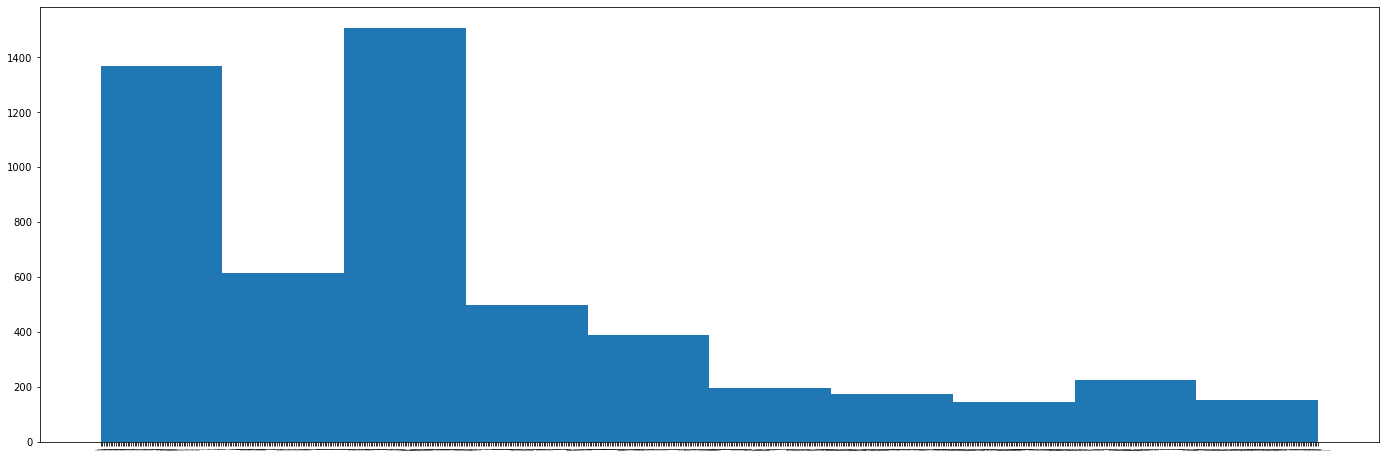

In [33]:
brenda_and_pubchem['Title'].hist(grid=False, figsize=(24,8), xlabelsize=0)

<AxesSubplot:>

<Figure size 1728x576 with 1 Axes>

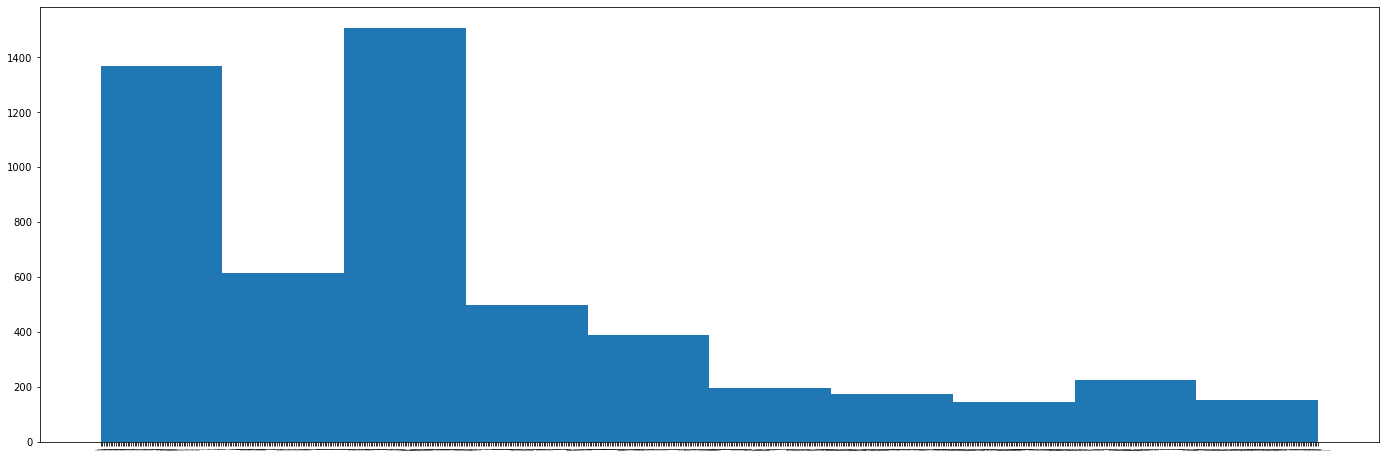

In [34]:
brenda_and_pubchem['Title'].hist(grid=False, figsize=(24,8), xlabelsize=0)

# Process Chemical Features

In [35]:
def create_morgan_fp(cmp):
    mol = Chem.MolFromSmiles(cmp)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, useChirality=True, radius=2, nBits=124)
    vec = np.array(fp)
    return vec

In [36]:
brenda_and_pubchem['MorganFingerprint'] = [create_morgan_fp(cmp) for cmp in brenda_and_pubchem['CanonicalSMILES'].values]

In [37]:
brenda_and_pubchem

,uniprot_ids,substrates,CID,CanonicalSMILES,IUPACName,Fingerprint2D,Title,MorganFingerprint
0,L0EKQ7,ginsenoside F2,9918692,CC(=CCCC(C)(C1CCC2(C1C(CC3C2(CCC4C3(CCC(C4(C)C...,"(2R,3S,4S,5R,6R)-2-(hydroxymethyl)-6-[[(3S,5R,...",AAADcfB8PAAAAAAAAAAAAAAAAAAAAYAAAAA0aMECAAAAAG...,ginsenoside F2,"[0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, ..."
1,H5U8W4,ginsenoside F2,9918692,CC(=CCCC(C)(C1CCC2(C1C(CC3C2(CCC4C3(CCC(C4(C)C...,"(2R,3S,4S,5R,6R)-2-(hydroxymethyl)-6-[[(3S,5R,...",AAADcfB8PAAAAAAAAAAAAAAAAAAAAYAAAAA0aMECAAAAAG...,ginsenoside F2,"[0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, ..."
2,D2KAT1,ginsenoside F2,9918692,CC(=CCCC(C)(C1CCC2(C1C(CC3C2(CCC4C3(CCC(C4(C)C...,"(2R,3S,4S,5R,6R)-2-(hydroxymethyl)-6-[[(3S,5R,...",AAADcfB8PAAAAAAAAAAAAAAAAAAAAYAAAAA0aMECAAAAAG...,ginsenoside F2,"[0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, ..."
3,A5IL43,ginsenoside F2,9918692,CC(=CCCC(C)(C1CCC2(C1C(CC3C2(CCC4C3(CCC(C4(C)C...,"(2R,3S,4S,5R,6R)-2-(hydroxymethyl)-6-[[(3S,5R,...",AAADcfB8PAAAAAAAAAAAAAAAAAAAAYAAAAA0aMECAAAAAG...,ginsenoside F2,"[0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, ..."
4,F7YVT1,ginsenoside F2,9918692,CC(=CCCC(C)(C1CCC2(C1C(CC3C2(CCC4C3(CCC(C4(C)C...,"(2R,3S,4S,5R,6R)-2-(hydroxymethyl)-6-[[(3S,5R,...",AAADcfB8PAAAAAAAAAAAAAAAAAAAAYAAAAA0aMECAAAAAG...,ginsenoside F2,"[0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, ..."
...,...,...,...,...,...,...,...,...
5272,A0A3G1VCA9,DIBOA beta-D-glucoside,10925943,C1=CC=C2C(=C1)N(C(=O)C(O2)OC3C(C(C(C(O3)CO)O)O...,"(2R)-4-hydroxy-2-[(2S,3R,4S,5S,6R)-3,4,5-trihy...",AAADceByPAAAAAAAAAAAAAAAAAAAAAAAAAA8SIAAAAAAAA...,DIBOA beta-D-glucoside,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
5273,Q9FYS3,DIBOA-glucoside,5316752,C1=CC=C2C(=C1)N(C(=O)C(O2)OC3C(C(C(C(O3)CO)O)O...,"4-hydroxy-2-[(2S,3R,4S,5S,6R)-3,4,5-trihydroxy...",AAADceByPAAAAAAAAAAAAAAAAAAAAAAAAAA8SIAAAAAAAA...,DIBOA-glucoside,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
5274,Q1XH05,DIBOA-glucoside,5316752,C1=CC=C2C(=C1)N(C(=O)C(O2)OC3C(C(C(C(O3)CO)O)O...,"4-hydroxy-2-[(2S,3R,4S,5S,6R)-3,4,5-trihydroxy...",AAADceByPAAAAAAAAAAAAAAAAAAAAAAAAAA8SIAAAAAAAA...,DIBOA-glucoside,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
5275,E8MGH8,beta-L-arabinofuranosyl-(1->2)-beta-L-arabinof...,71306364,C(C1C(C(C(O1)O)OC2C(C(C(O2)CO)O)O)O)O,"(2S,3R,4S,5S)-3-[(2R,3R,4R,5S)-3,4-dihydroxy-5...",AAADceBwPAAAAAAAAAAAAAAAAAAAASJAAAAAAAAAAAAAAA...,beta-L-arabinofuranosyl-(1->2)-beta-L-arabinof...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."


# Get UniProt AA Sequences

In [40]:
def get_uniprot_entry_by_id(idx, uniprot_id):
    #print(f"UID: {uniprot_id}")
    r = requests.get(f"https://www.ebi.ac.uk/proteins/api/proteins/{uniprot_id}")
    
    try:
        try:
            aa_sequence = json.loads(r.text)['sequence']['sequence']
        except:
            aa_sequence = np.nan
            
        try:
            uniprot_accession = json.loads(r.text)['accession']
        except:
            uniprot_accession = np.nan
            
        try:
            uniprot_name = json.loads(r.text)['protein']['submittedName'][0]['fullName']['value']
        except:
            uniprot_name = np.nan
            
        try:
            uniprot_ec = json.loads(r.text)['protein']['submittedName'][0]['ecNumber'][0]['value']
        except:
            uniprot_ec = np.nan
            
        try:
            pfam_ids = ';'.join([i['id'] for i in json.loads(r.text)['dbReferences'] if i['type']=='Pfam'])
        except:
            pfam_ids = np.nan
        
        return pd.DataFrame(data={
            'index':[idx],
            'aa_sequence':aa_sequence,
            'uniprot_accession':uniprot_accession,
            'uniprot_name':uniprot_name,
            'uniprot_ec':uniprot_ec,
            'pfam_ids':pfam_ids
        })
        
    except Exception as e:
        print(f"exception: {e}")
        pass

In [42]:
window_size = 100

slices = range( (int(len(brenda_and_pubchem['uniprot_ids'].unique()) / window_size) + 1) )

uids = list(brenda_and_pubchem['uniprot_ids'].unique())

request_data_chunks = []

existing_chunks = glob.glob("uniprot_seq_chunks/*")
                            
for idx, slice_num in enumerate(slices):
    outfile_name =  f"uniprot_seq_chunks/uniprot_seqs_chunk_{idx}.tsv"
    if outfile_name not in existing_chunks:
        try:
            time.sleep(5)
            print(f"processing chunk {idx} of {len(list(slices))}... in window[{slice_num*window_size}:{(slice_num*window_size)+window_size}]")
            pd.concat([get_uniprot_entry_by_id(idx,uid) for idx,uid in enumerate(uids[slice_num*window_size:(slice_num*window_size)+window_size]) ]).to_csv(
                f"uniprot_seq_chunks/uniprot_seqs_chunk_{idx}.tsv", sep='\t')
        except Exception as e:
            print(f"ran into exception on slice number {idx}: {e}")
    else:
        print(f"{outfile_name} already exists, skipping processing for chunk {idx}...")

processing chunk 0 of 43... in window[0:100]
processing chunk 1 of 43... in window[100:200]
processing chunk 2 of 43... in window[200:300]
processing chunk 3 of 43... in window[300:400]
processing chunk 4 of 43... in window[400:500]
processing chunk 5 of 43... in window[500:600]
processing chunk 6 of 43... in window[600:700]
processing chunk 7 of 43... in window[700:800]
processing chunk 8 of 43... in window[800:900]
processing chunk 9 of 43... in window[900:1000]
processing chunk 10 of 43... in window[1000:1100]
processing chunk 11 of 43... in window[1100:1200]
processing chunk 12 of 43... in window[1200:1300]
processing chunk 13 of 43... in window[1300:1400]
processing chunk 14 of 43... in window[1400:1500]
processing chunk 15 of 43... in window[1500:1600]
processing chunk 16 of 43... in window[1600:1700]
processing chunk 17 of 43... in window[1700:1800]
processing chunk 18 of 43... in window[1800:1900]
processing chunk 19 of 43... in window[1900:2000]
processing chunk 20 of 43... in

In [43]:
pd.concat([pd.read_csv(i, sep="\t") for i in glob.glob("uniprot_seq_chunks/*")]).to_csv("uniprot_all_seqs_clean_new.tsv", sep="\t")

In [52]:
#uniprot_all_seqs = pd.read_csv("uniprot_all_seqs_clean.tsv", sep='\t')
uniprot_all_seqs = pd.read_csv("uniprot_all_seqs_clean_new.tsv", sep='\t')
uniprot_all_seqs = uniprot_all_seqs[[i for i in uniprot_all_seqs.columns if not i.startswith('Unnamed')]]

In [53]:
uniprot_all_seqs

,index,aa_sequence,uniprot_accession,uniprot_name,uniprot_ec,pfam_ids
0,0,MMTLNLQTMSSNDMLNFGKKPAYTTSNGSMYIGDSLELLESFPDES...,P11409,NaN,NaN,PF01555
1,1,MLLIVNENEPDTSTHTDEPIQEPARGRLVVGDARKVLAGMADKSFQ...,Q3BWM2,NaN,NaN,PF01555
2,2,MENLKFDLFLSNVDIDFKDYKIKESVHGIHSYPAMMPAPLAEFLIQ...,B9MK94,NaN,NaN,PF01555
3,3,MNAEKSPVNHNVDHEEIAKFEAVASRWWDLEGEFKPLHRINPLRLG...,P17993,NaN,NaN,NaN
4,4,EGANFLAGLGSLGRLICIPMALKAALDLQVFEIIASAGAGSHLSAS...,A0A5P9PAM0,(S)-scoulerine 9-O-methyltransferase,2.1.1.117,PF08100;PF00891
...,...,...,...,...,...,...
4283,95,MHGKLIGVGVGPGDSELLTLRAVNVLRSVPVICAPRSSSERESIAL...,O27402,Precorrin-2 methyltransferase,NaN,PF00590
4284,96,MNNQGSIISVSLGPGDPGLITVKALSQLREADVIYYPGTVSASGAV...,Q8KFD9,Precorrin-2 C20-methyltransferase,2.1.1.130,PF00590
4285,97,MNTTTEQDFGADPTKVRDTDHYTEEYVDGFVDKWDDLIDWDSRAKS...,Q9KJ22,NaN,NaN,PF13649
4286,98,MTKSVDDLARGDQAGDEQDPVHREQQTFGDNPLEVRDTDHYMHEYV...,Q9KJ20,NaN,NaN,PF08241;PF13649


# Combine AA, Compound, and BRENDA Data

In [54]:
all_data_combined = brenda_and_pubchem.merge(uniprot_all_seqs, left_on='uniprot_ids', right_on='uniprot_accession', how='inner')
all_data_combined_clean = all_data_combined.drop(['uniprot_accession','index','Title'], axis=1)

In [55]:
all_data_combined_clean.to_csv('all_data_combined_clean.tsv', sep='\t')